<a href="https://colab.research.google.com/github/helmenov/mirai-kougaku/blob/master/QuantileRegression_cos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install numpy==1.18.2
!pip install tensorflow==2.2.0rc3
!pip install matplotlib==3.2.1

     |████████████████████████████████| 20.2MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.3
    Uninstalling numpy-1.18.3:
      Successfully uninstalled numpy-1.18.3


In [0]:
import numpy as np
from more_itertools import windowed
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Activation
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x=np.linspace(0,10.0*np.pi,num=500)
ampl=1.0
f=np.vectorize(np.cos)(x)+(ampl*np.random.normal(size=len(x)))
f=np.array(f,dtype='float32')

In [0]:
w=50 #window size
input=(np.array(list(windowed(f,w)))[:-1].reshape(len(f)-w,w,1))
output=[f[w:].reshape(len(f)-w,1)]
input_train=input[:110]
output_train=output[:110]

In [0]:
def tilted_loss(q,y,f):
  e = (y-f)
  return K.mean(K.maximum(q*e, (q-1.0)*e),axis=-1)

In [0]:
in_out_neurons = 1
n_hidden = 100

model_upper = Sequential()
model_middle = Sequential()
model_lower = Sequential()
model_upper.add(LSTM(n_hidden))
model_middle.add(LSTM(n_hidden))
model_lower.add(LSTM(n_hidden))
model_upper.add(Dense(in_out_neurons))
model_middle.add(Dense(in_out_neurons))
model_lower.add(Dense(in_out_neurons))
model_upper.add(Activation("linear"))
model_middle.add(Activation("linear"))
model_lower.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model_upper.compile(loss=lambda y,f: tilted_loss(0.975,y,f),optimizer=optimizer)
model_middle.compile(loss=lambda y,f: tilted_loss(0.5,y,f),optimizer=optimizer)
model_lower.compile(loss=lambda y,f: tilted_loss(0.025,y,f),optimizer=optimizer)
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'auto', patience =40)

In [0]:
model_upper.fit(input_train,output_train, batch_size=200, epochs=500, validation_split=0.1, callbacks =[early_stopping])
model_middle.fit(input_train,output_train, batch_size=200, epochs=500, validation_split=0.1, callbacks =[early_stopping])
model_lower.fit(input_train,output_train, batch_size=200, epochs=500, validation_split=0.1, callbacks =[early_stopping])

Epoch 1/500
1/1 [==============================] - 1s 524ms/step - loss: 0.4440 - val_loss: 0.1217
Epoch 2/500
1/1 [==============================] - 0s 41ms/step - loss: 0.4319 - val_loss: 0.1299
Epoch 3/500
1/1 [==============================] - 0s 38ms/step - loss: 0.4196 - val_loss: 0.1370
Epoch 4/500
1/1 [==============================] - 0s 43ms/step - loss: 0.4072 - val_loss: 0.1398
Epoch 5/500
1/1 [==============================] - 0s 40ms/step - loss: 0.3942 - val_loss: 0.1383
Epoch 6/500
1/1 [==============================] - 0s 41ms/step - loss: 0.3791 - val_loss: 0.1332
Epoch 7/500
1/1 [==============================] - 0s 43ms/step - loss: 0.3604 - val_loss: 0.1248
Epoch 8/500
1/1 [==============================] - 0s 39ms/step - loss: 0.3363 - val_loss: 0.1123
Epoch 9/500
1/1 [==============================] - 0s 41ms/step - loss: 0.3052 - val_loss: 0.0952
Epoch 10/500
1/1 [==============================] - 0s 41ms/step - loss: 0.2657 - val_loss: 0.0815
Epoch 11/500
1/1 [

In [0]:
predicted_upper = model_upper.predict(input)
predicted_middle = model_middle.predict(input)
predicted_lower = model_lower.predict(input)

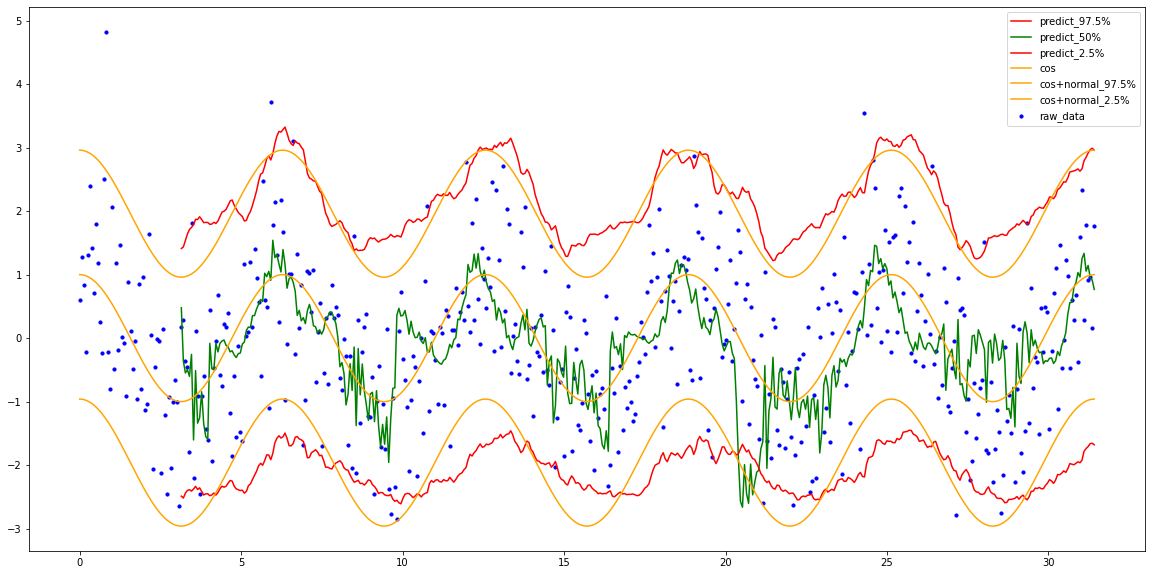

In [0]:
plt.figure(figsize=(20,10))
plt.plot(x[w:],predicted_upper, color="r", label="predict_97.5%")
plt.plot(x[w:],predicted_middle, color="g", label="predict_50%")
plt.plot(x[w:],predicted_lower, color="r", label="predict_2.5%")
plt.scatter(x, f, color="b", label="raw_data", s=10)
plt.plot(x,np.vectorize(np.cos)(x),color="orange", label="cos")
plt.plot(x,np.vectorize(np.cos)(x)+ampl*1.96*np.ones(len(x)),color="orange", label="cos+normal_97.5%")
plt.plot(x,np.vectorize(np.cos)(x)+ampl*(-1.96)*np.ones(len(x)),color="orange", label="cos+normal_2.5%")
plt.legend()
plt.show()

# グラフの見方
オレンジ色のグラフは理論値（神の視点）を表示しました。

青い点は観測された実際の値になります。

赤い線は区間[0,2π+α]での観測値を学習して、95%予測区間の境界を人工知能に作らせたものです。青い点の95％ぐらいがこの赤い線に入っているはずです。

緑の線は中央値を予測しています。

オレンジの線（理論値）と赤や緑の線（予測値）が大体重なっていれば予測成功です。重なり具合が高ければ高いほど予測精度が高いと言えます。ただ、ノイズはかなりの量を学習しないと再現が難しいので、ぴったり重ねるのは無理だと思います。（もしそれができるなら宝くじの当選番号を当てることができます）

コサイン波は予測しやすいですが、ノイズの傾向は予測しずらいということがわかりましたでしょうか？